# Final Exam (part 3) - Computational Physics 2

### Deadline: Friday 6 June 2025 (by 23h59)
### Credits: 10 points

### Please keep the structure provided below and submit an organised notebook with clear answers to each item.


## 3. MPI Parallelisation of Molecular Dynamics Simulations

In this problem, you will use **Message Passing Interface (MPI)** library to parallelise the execution of molecular dynamics simulations for different temperatures. The goal is to distribute the simulation of various temperatures across multiple MPI processes, significantly reducing the overall computational time.

### Code:
The reference (serial) script can be found here:

https://github.com/wbandabarragan/computational-physics-2/blob/main/exams/thermostat.py

**You should only modify the code below the indicated line:**

`# Your MPI parallelization code should start here. Do not modify the code above.`

The core simulation logic within the `run` function should remain untouched.

### Tasks:

Use the provided script (`thermostat.py`) to create a new version of the script (`thermostat_mpi.py`) that uses the `mpi4py` library to parallelise the simulation execution. Here are the specific requirements for your MPI implementation:

**(a)** Set up a world communicator to distribute tasks among processes. Determine the rank of each process and the total number of processes.

**(b)** Distribute a range of temperatures among the available MPI processes. Each process should be responsible for running the simulation at one or more unique temperatures.

**(c)** Ensure proper initialization and finalization of the MPI environment. Cores should also send completion signals.

**(d)** The root/master process (rank 0) should handle workload communications and collect the simulation results from all other processes.

**(e)** For each simulated temperature, generate the `temperature-N_atoms.png` plot and the `traj-hydrogen-3D-N_atoms.dump` file. In addition the root/master process should:

- Collect and present the combined results (i.e., a single plot with all the temperature curves).

- Save the total execution time and the number of CPU cores used to a CSV file (`mpi_scaling.csv`). 

**(f)** Run the script with `mpirun` and different number of processors in an HPC facility.

### Scaling and analysis:

Report the simulation results (temperature plots and scaling) in this notebook:

**(g)** After running the MPI code for various numbers of CPU cores (e.g., 1, 2, 4, 8, 16, etc.), use the data accumulated in the CSV file (`mpi_scaling.csv`) from multiple runs to:

- Plot the observed speedup (e.g., $S_p = T_1 / T_p$, where $T_1$ is the execution time on 1 CPU and $T_p$ is the execution time on $p$ CPUs) as a function of the number of CPU cores.

- Compare your observed speedup to Amdahl's Law and discuss any discrepancies between the observed and theoretical speedup.

In [ ]:
# !/usr/bin/python
"""
A molecular dynamics solver that simulates the motion of non-interacting particles
in the canonical ensemble using a Langevin thermostat.
Reference: https://github.com/Comp-science-engineering/Tutorials/tree/master/MolecularDynamics
"""
import time
import numpy as np
import matplotlib.pyplot as plt

# Define global physical constants
from scipy.constants import Avogadro, Boltzmann

def wallHitCheck(pos, vels, box):
    """ This function enforces reflective boundary conditions.
    All particles that hit a wall  have their velocity updated
    in the opposite direction.
    @pos: atomic positions (ndarray)
    @vels: atomic velocity (ndarray, updated if collisions detected)
    @box: simulation box size (tuple)
    """
    ndims = len(box)

    for i in range(ndims):
        vels[((pos[:,i] <= box[i][0]) | (pos[:,i] >= box[i][1])),i] *= -1

def integrate(pos, vels, forces, mass,  dt):
    """ A simple forward Euler integrator that moves the system in time 
    @pos: atomic positions (ndarray, updated)
    @vels: atomic velocity (ndarray, updated)
    """
    pos += vels * dt
    vels += forces * dt / mass[np.newaxis].T

def computeForce(mass, vels, temp, relax, dt):
    """ Computes the Langevin force for all particles
    @mass: particle mass (ndarray)
    @vels: particle velocities (ndarray)
    @temp: temperature (float)
    @relax: thermostat constant (float)
    @dt: simulation timestep (float)
    returns forces (ndarray)
    """
    natoms, ndims = vels.shape

    sigma = np.sqrt(2.0 * mass * temp * Boltzmann / (relax * dt))
    noise = np.random.randn(natoms, ndims) * sigma[np.newaxis].T

    force = - (vels * mass[np.newaxis].T) / relax + noise

    return force

def run(**args):
    """ This is the main function that solves Langevin's equations for
    a system of natoms usinga forward Euler scheme, and returns an output
    list that stores the time and the temperture.
    @natoms (int): number of particles
    @temp (float): temperature (in Kelvin)
    @mass (float): particle mass (in Kg)
    @relax (float): relaxation constant (in seconds)
    @dt (float): simulation timestep (s)
    @nsteps (int): total number of steps the solver performs
    @box (tuple): simulation box size (in meters) of size dimensions x 2
    e.g. box = ((-1e-9, 1e-9), (-1e-9, 1e-9)) defines a 2D square
    @ofname (string): filename to write output to
    @freq (int): write output every 'freq' steps
    @[radius]: particle radius (for visualization)
    Returns a list (of size nsteps x 2) containing the time and temperature.
    
    """

    natoms, box, dt, temp = args['natoms'], args['box'], args['dt'], args['temp']
    mass, relax, nsteps   = args['mass'], args['relax'], args['steps']
    ofname, freq, radius = args['ofname'], args['freq'], args['radius']

    dim = len(box)
    pos = np.random.rand(natoms,dim)

    for i in range(dim):
        pos[:,i] = box[i][0] + (box[i][1] -  box[i][0]) * pos[:,i]

    vels = np.random.rand(natoms,dim)
    mass = np.ones(natoms) * mass / Avogadro
    radius = np.ones(natoms) * radius
    step = 0

    output = []

    while step <= nsteps:

        step += 1

        # Compute all forces
        forces = computeForce(mass, vels, temp, relax, dt)

        # Move the system in time
        integrate(pos, vels, forces, mass, dt)

        # Check if any particle has collided with the wall
        wallHitCheck(pos,vels,box)

        # Compute output (temperature)
        ins_temp = np.sum(np.dot(mass, (vels - vels.mean(axis=0))**2)) / (Boltzmann * dim * natoms)
        output.append([step * dt, ins_temp])

        if not step%freq:
            #dump.writeOutput(ofname, natoms, step, box, radius=radius, pos=pos, v=vels)
            writeOutput(ofname, natoms, step, box, radius=radius, pos=pos, v=vels)
    return np.array(output)


def writeOutput(filename, natoms, timestep, box, **data):
    """ Writes the output (in dump format) """

    axis = ('x', 'y', 'z')

    with open(filename, 'a') as fp:

        fp.write('ITEM: TIMESTEP\n')
        fp.write('{}\n'.format(timestep))

        fp.write('ITEM: NUMBER OF ATOMS\n')
        fp.write('{}\n'.format(natoms))

        fp.write('ITEM: BOX BOUNDS' + ' f' * len(box) + '\n')
        for box_bounds in box:
            fp.write('{} {}\n'.format(*box_bounds))

        for i in range(len(axis) - len(box)):
            fp.write('0 0\n')

        keys = list(data.keys())

        for key in keys:
            isMatrix = len(data[key].shape) > 1

            if isMatrix:
                _, nCols = data[key].shape

                for i in range(nCols):
                    if key == 'pos':
                        data['{}'.format(axis[i])] = data[key][:,i]
                    else:
                        data['{}_{}'.format(key,axis[i])] = data[key][:,i]

                del data[key]

        keys = data.keys()

        fp.write('ITEM: ATOMS' + (' {}' * len(data)).format(*data) + '\n')

        output = []
        for key in keys:
            output = np.hstack((output, data[key]))

        if len(output):
            np.savetxt(fp, output.reshape((natoms, len(data)), order='F'))

# -----------------------------------------------------------------------------
# Your MPI parallelization code should start here. Do not modify the code above.
# -----------------------------------------------------------------------------

import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import Avogadro, Boltzmann
import os
import csv
from mpi4py import MPI

from thermostat import run  
# MPI setup
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Temperatures to simulate
temperatures = [250, 275, 300, 325, 350, 375, 400, 425, 450, 475]
N_atoms = 1000

# Base simulation parameters
base_params = {
    'natoms': N_atoms,
    'mass': 0.001,
    'radius': 120e-12,
    'relax': 1e-13,
    'dt': 1e-15,
    'steps': 10000,
    'freq': 100,
    'box': ((0, 1e-8), (0, 1e-8), (0, 1e-8)),
}

def write_scaling_csv(filename, cores, exec_time):
    header = ['n_cores', 'execution_time']
    file_exists = os.path.isfile(filename)
    with open(filename, 'a', newline='') as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow(header)
        writer.writerow([cores, exec_time])

if __name__ == "__main__":
    # Start timing
    start_time = time.time()

    # Distribute temperatures evenly among processes
    local_temps = [temp for i, temp in enumerate(temperatures) if i % size == rank]

    local_results = []

    for temp in local_temps:
        print(f"Process {rank}: Simulating temperature {temp}K")
        params = base_params.copy()
        params['temp'] = temp
        params['ofname'] = f'traj-hydrogen-3D-{N_atoms}-{temp}K.dump'

        output = run(**params)

        # Save individual plot
        plt.figure(figsize=(6, 5))
        plt.plot(output[:, 0] * 1e12, output[:, 1])
        plt.xlabel('Time (ps)')
        plt.ylabel('Temperature (K)')
        plt.title(f'Temperature Evolution at {temp}K')
        plt.tight_layout()
        plt.savefig(f'temperature-{N_atoms}-{temp}K.png')
        plt.close()

        local_results.append((temp, output))

    # Gather results at root
    all_results = comm.gather(local_results, root=0)

    # Root process handles aggregation
    if rank == 0:
        combined_results = []
        for proc_data in all_results:
            combined_results.extend(proc_data)

        # Sort by temperature
        combined_results.sort(key=lambda x: x[0])

        # Plot all temperature curves
        plt.figure(figsize=(10, 7))
        for temp, output in combined_results:
            plt.plot(output[:, 0] * 1e12, output[:, 1], label=f'{temp}K')

        plt.xlabel('Time (ps)')
        plt.ylabel('Temperature (K)')
        plt.title(f'Temperature Evolution for All Simulations ({N_atoms} atoms)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'combined-temperature-{N_atoms}.png', dpi=300)
        plt.close()

        # Compute and store total execution time
        exec_time = time.time() - start_time
        print(f"Total execution time using {size} cores: {exec_time:.2f} seconds")

        write_scaling_csv('mpi_scaling.csv', size, exec_time)

    # Finalize MPI (optional, usually implicit)
    MPI.Finalize()


Process 0: Simulating temperature 250K
Process 0: Simulating temperature 275K
Process 0: Simulating temperature 300K
Process 0: Simulating temperature 325K
Process 0: Simulating temperature 350K
Process 0: Simulating temperature 375K
Process 0: Simulating temperature 400K
Process 0: Simulating temperature 425K
Process 0: Simulating temperature 450K
Process 0: Simulating temperature 475K
Total execution time using 1 cores: 21.63 seconds


This Next code is for running a mpi paralelization work in my own pc

In [ ]:
%%bash
mpirun -n 8 python -c "
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import Avogadro, Boltzmann
import os
import csv
from mpi4py import MPI

# !/usr/bin/python
"""
A molecular dynamics solver that simulates the motion of non-interacting particles
in the canonical ensemble using a Langevin thermostat.
Reference: https://github.com/Comp-science-engineering/Tutorials/tree/master/MolecularDynamics
"""
import time
import numpy as np
import matplotlib.pyplot as plt

# Define global physical constants
from scipy.constants import Avogadro, Boltzmann

def wallHitCheck(pos, vels, box):
    """ This function enforces reflective boundary conditions.
    All particles that hit a wall  have their velocity updated
    in the opposite direction.
    @pos: atomic positions (ndarray)
    @vels: atomic velocity (ndarray, updated if collisions detected)
    @box: simulation box size (tuple)
    """
    ndims = len(box)

    for i in range(ndims):
        vels[((pos[:,i] <= box[i][0]) | (pos[:,i] >= box[i][1])),i] *= -1

def integrate(pos, vels, forces, mass,  dt):
    """ A simple forward Euler integrator that moves the system in time 
    @pos: atomic positions (ndarray, updated)
    @vels: atomic velocity (ndarray, updated)
    """
    pos += vels * dt
    vels += forces * dt / mass[np.newaxis].T

def computeForce(mass, vels, temp, relax, dt):
    """ Computes the Langevin force for all particles
    @mass: particle mass (ndarray)
    @vels: particle velocities (ndarray)
    @temp: temperature (float)
    @relax: thermostat constant (float)
    @dt: simulation timestep (float)
    returns forces (ndarray)
    """
    natoms, ndims = vels.shape

    sigma = np.sqrt(2.0 * mass * temp * Boltzmann / (relax * dt))
    noise = np.random.randn(natoms, ndims) * sigma[np.newaxis].T

    force = - (vels * mass[np.newaxis].T) / relax + noise

    return force

def run(**args):
    """ This is the main function that solves Langevin's equations for
    a system of natoms usinga forward Euler scheme, and returns an output
    list that stores the time and the temperture.
    @natoms (int): number of particles
    @temp (float): temperature (in Kelvin)
    @mass (float): particle mass (in Kg)
    @relax (float): relaxation constant (in seconds)
    @dt (float): simulation timestep (s)
    @nsteps (int): total number of steps the solver performs
    @box (tuple): simulation box size (in meters) of size dimensions x 2
    e.g. box = ((-1e-9, 1e-9), (-1e-9, 1e-9)) defines a 2D square
    @ofname (string): filename to write output to
    @freq (int): write output every 'freq' steps
    @[radius]: particle radius (for visualization)
    Returns a list (of size nsteps x 2) containing the time and temperature.
    
    """

    natoms, box, dt, temp = args['natoms'], args['box'], args['dt'], args['temp']
    mass, relax, nsteps   = args['mass'], args['relax'], args['steps']
    ofname, freq, radius = args['ofname'], args['freq'], args['radius']

    dim = len(box)
    pos = np.random.rand(natoms,dim)

    for i in range(dim):
        pos[:,i] = box[i][0] + (box[i][1] -  box[i][0]) * pos[:,i]

    vels = np.random.rand(natoms,dim)
    mass = np.ones(natoms) * mass / Avogadro
    radius = np.ones(natoms) * radius
    step = 0

    output = []

    while step <= nsteps:

        step += 1

        # Compute all forces
        forces = computeForce(mass, vels, temp, relax, dt)

        # Move the system in time
        integrate(pos, vels, forces, mass, dt)

        # Check if any particle has collided with the wall
        wallHitCheck(pos,vels,box)

        # Compute output (temperature)
        ins_temp = np.sum(np.dot(mass, (vels - vels.mean(axis=0))**2)) / (Boltzmann * dim * natoms)
        output.append([step * dt, ins_temp])

        if not step%freq:
            #dump.writeOutput(ofname, natoms, step, box, radius=radius, pos=pos, v=vels)
            writeOutput(ofname, natoms, step, box, radius=radius, pos=pos, v=vels)
    return np.array(output)


def writeOutput(filename, natoms, timestep, box, **data):
    """ Writes the output (in dump format) """

    axis = ('x', 'y', 'z')

    with open(filename, 'a') as fp:

        fp.write('ITEM: TIMESTEP\n')
        fp.write('{}\n'.format(timestep))

        fp.write('ITEM: NUMBER OF ATOMS\n')
        fp.write('{}\n'.format(natoms))

        fp.write('ITEM: BOX BOUNDS' + ' f' * len(box) + '\n')
        for box_bounds in box:
            fp.write('{} {}\n'.format(*box_bounds))

        for i in range(len(axis) - len(box)):
            fp.write('0 0\n')

        keys = list(data.keys())

        for key in keys:
            isMatrix = len(data[key].shape) > 1

            if isMatrix:
                _, nCols = data[key].shape

                for i in range(nCols):
                    if key == 'pos':
                        data['{}'.format(axis[i])] = data[key][:,i]
                    else:
                        data['{}_{}'.format(key,axis[i])] = data[key][:,i]

                del data[key]

        keys = data.keys()

        fp.write('ITEM: ATOMS' + (' {}' * len(data)).format(*data) + '\n')

        output = []
        for key in keys:
            output = np.hstack((output, data[key]))

        if len(output):
            np.savetxt(fp, output.reshape((natoms, len(data)), order='F'))

# MPI setup
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Your main simulation code
temperatures = [250, 275, 300, 325, 350, 375, 400, 425, 450, 475]
N_atoms = 1000

base_params = {
    'natoms': N_atoms,
    'mass': 0.001,
    'radius': 120e-12,
    'relax': 1e-13,
    'dt': 1e-15,
    'steps': 10000,
    'freq': 100,
    'box': ((0, 1e-8), (0, 1e-8), (0, 1e-8)),
}

start_time = time.time()
local_temps = [temp for i, temp in enumerate(temperatures) if i % size == rank]
local_results = []

for temp in local_temps:
    print(f'Process {rank}: Simulating temperature {temp}K')
    params = base_params.copy()
    params['temp'] = temp
    params['ofname'] = f'traj-hydrogen-3D-{N_atoms}-{temp}K.dump'
    output = run(**params)
    local_results.append((temp, output))

all_results = comm.gather(local_results, root=0)

if rank == 0:
    combined_results = []
    for proc_data in all_results:
        combined_results.extend(proc_data)
    combined_results.sort(key=lambda x: x[0])
    
    exec_time = time.time() - start_time
    print(f'Total execution time using {size} cores: {exec_time:.2f} seconds')
    write_scaling_csv('mpi_scaling.csv', size, exec_time)

MPI.Finalize()
"


Process 1: Simulating temperature 275K
Process 5: Simulating temperature 375K
Process 6: Simulating temperature 400K
Process 2: Simulating temperature 300K
Process 0: Simulating temperature 250K
Process 3: Simulating temperature 325K
Process 7: Simulating temperature 425K
Process 4: Simulating temperature 350K
Process 1: Simulating temperature 475K
Process 0: Simulating temperature 450K
Total execution time using 8 cores: 4.79 seconds


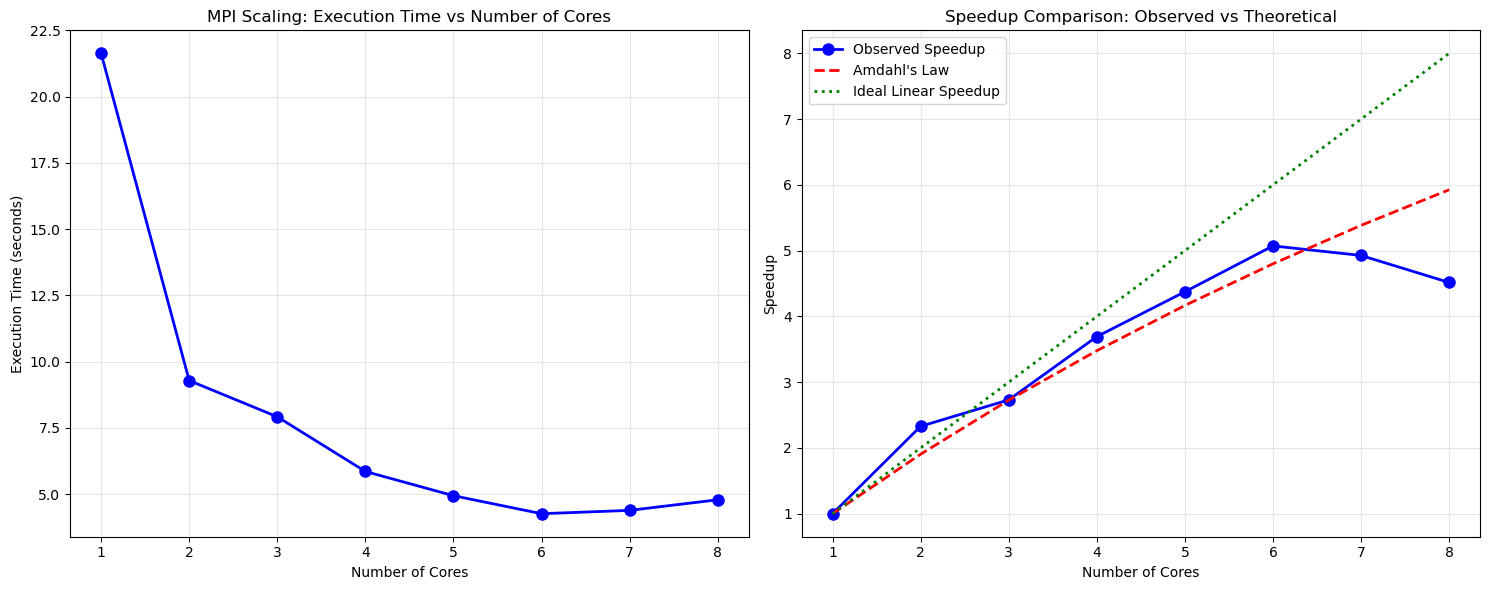

Scaling Analysis:
Maximum observed speedup: 5.07x with 6 cores
Efficiency at maximum cores (8): 56.4%

Efficiency by core count:
  1 cores: 100.0%
  2 cores: 116.4%
  3 cores: 91.0%
  4 cores: 92.3%
  5 cores: 87.5%
  6 cores: 84.5%
  7 cores: 70.4%
  8 cores: 56.4%


In [24]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Read the scaling data
my_pc = pd.read_csv('mpi_scaling.csv')

# Calculate speedup from the data (S_p = T_1 / T_p)
speedup = my_pc['execution_time'].iloc[0] / my_pc['execution_time']
my_pc['speedup'] = speedup

# Calculate theoretical Amdahl's Law speedup
p = 0.95
amdahl_speedup_data = 1 / ((1 - p) + p / my_pc['n_cores'])

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Execution Time vs Number of Cores
ax1.plot(my_pc['n_cores'], my_pc['execution_time'], marker='o', linestyle='-', color='b', linewidth=2, markersize=8)
ax1.set_title('MPI Scaling: Execution Time vs Number of Cores')
ax1.set_xlabel('Number of Cores')
ax1.set_ylabel('Execution Time (seconds)')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(my_pc['n_cores'])

# Plot 2: Speedup Comparison
ax2.plot(my_pc['n_cores'], my_pc['speedup'], marker='o', linestyle='-', color='b', linewidth=2, markersize=8, label='Observed Speedup')
ax2.plot(my_pc['n_cores'], amdahl_speedup_data, linestyle='--', color='r', linewidth=2, label="Amdahl's Law")
ax2.plot(my_pc['n_cores'], my_pc['n_cores'], linestyle=':', color='g', linewidth=2, label='Ideal Linear Speedup')
ax2.set_title('Speedup Comparison: Observed vs Theoretical')
ax2.set_xlabel('Number of Cores')
ax2.set_ylabel('Speedup')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xticks(my_pc['n_cores'])

plt.tight_layout()
plt.show()

# Print detailed analysis
print("Scaling Analysis:")
print(f"Maximum observed speedup: {my_pc['speedup'].max():.2f}x with {my_pc.loc[my_pc['speedup'].idxmax(), 'n_cores']} cores")
print(f"Efficiency at maximum cores ({my_pc['n_cores'].iloc[-1]}): {(my_pc['speedup'].iloc[-1] / my_pc['n_cores'].iloc[-1] * 100):.1f}%")

# Calculate efficiency for each core count
my_pc['efficiency'] = my_pc['speedup'] / my_pc['n_cores'] * 100
print(f"\nEfficiency by core count:")
for _, row in my_pc.iterrows():
    print(f"  {int(row['n_cores'])} cores: {row['efficiency']:.1f}%")

Then i used the same script to run in hpc Cedia

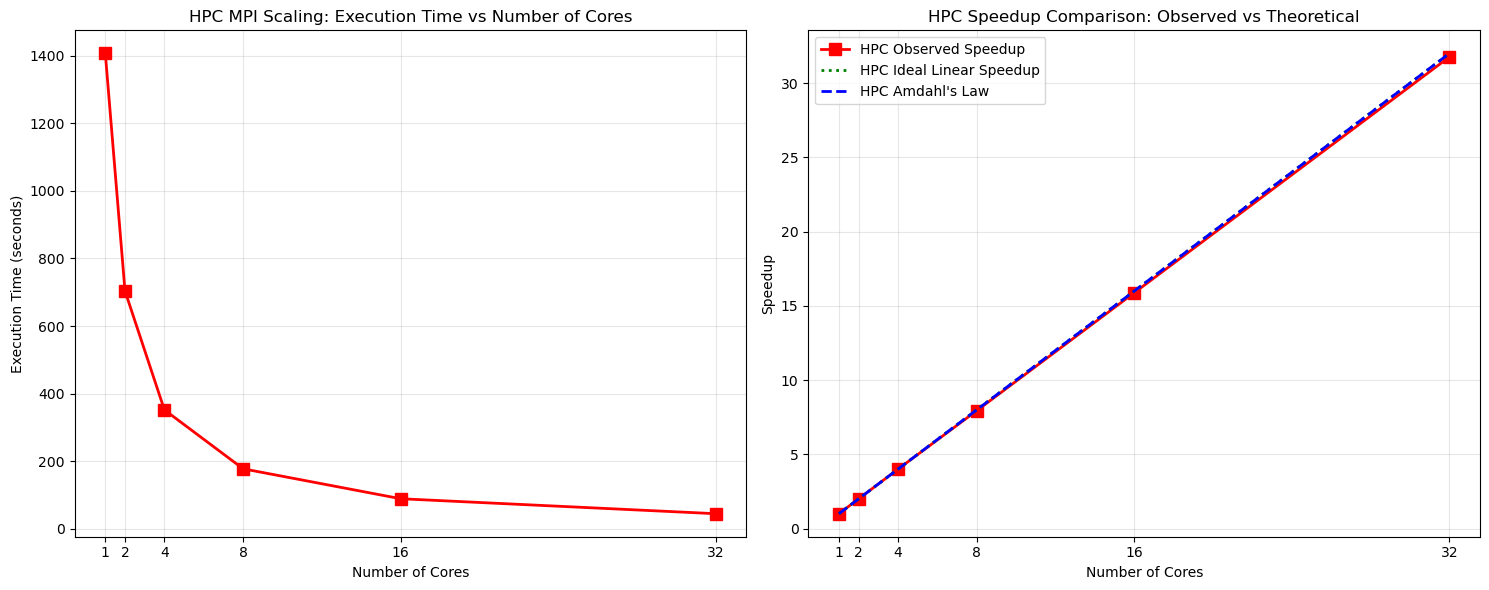

HPC Scaling Analysis:
Maximum observed speedup: 31.76x with 32 cores
Efficiency at maximum cores (32): 99.3%

HPC Efficiency by core count:
  1 cores: 100.0%
  2 cores: 100.0%
  4 cores: 100.0%
  8 cores: 99.3%
  16 cores: 99.3%
  32 cores: 99.3%


In [26]:
# Read the HPC scaling data
hpc = pd.read_csv('mpi_scaling_hpc.csv')

# Calculate speedup from the HPC data (S_p = T_1 / T_p)
speedup_hpc = hpc['execution_time'].iloc[0] / hpc['execution_time']
hpc['speedup'] = speedup_hpc

# Calculate theoretical Amdahl's Law speedup for HPC data
p = 1
amdahl_speedup_hpc = 1 / ((1 - p) + p / hpc['n_cores'])

# Create two subplots for HPC data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Execution Time vs Number of Cores (HPC)
ax1.plot(hpc['n_cores'], hpc['execution_time'], marker='s', linestyle='-', color='r', linewidth=2, markersize=8)
ax1.set_title('HPC MPI Scaling: Execution Time vs Number of Cores')
ax1.set_xlabel('Number of Cores')
ax1.set_ylabel('Execution Time (seconds)')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(hpc['n_cores'])

# Plot 2: Speedup Comparison (HPC)
ax2.plot(hpc['n_cores'], hpc['speedup'], marker='s', linestyle='-', color='r', linewidth=2, markersize=8, label='HPC Observed Speedup')
ax2.plot(hpc['n_cores'], hpc['n_cores'], linestyle=':', color='g', linewidth=2, label='HPC Ideal Linear Speedup')
ax2.plot(hpc['n_cores'], amdahl_speedup_hpc, linestyle='--', color='b', linewidth=2, label="HPC Amdahl's Law")
ax2.set_title('HPC Speedup Comparison: Observed vs Theoretical')
ax2.set_xlabel('Number of Cores')
ax2.set_ylabel('Speedup')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xticks(hpc['n_cores'])

plt.tight_layout()
plt.show()

# Print detailed analysis for HPC
print("HPC Scaling Analysis:")
print(f"Maximum observed speedup: {hpc['speedup'].max():.2f}x with {hpc.loc[hpc['speedup'].idxmax(), 'n_cores']} cores")
print(f"Efficiency at maximum cores ({hpc['n_cores'].iloc[-1]}): {(hpc['speedup'].iloc[-1] / hpc['n_cores'].iloc[-1] * 100):.1f}%")



# Calculate efficiency for each core count (HPC)
hpc['efficiency'] = hpc['speedup'] / hpc['n_cores'] * 100
print(f"\nHPC Efficiency by core count:")
for _, row in hpc.iterrows():
    print(f"  {int(row['n_cores'])} cores: {row['efficiency']:.1f}%")
